# Import all the required libraries

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read the detailed class file

In [67]:
stage1ClassDF = pd.read_csv('./rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
stage1ClassDF.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [68]:
# Get statistical information about detailed class dataset
stage1ClassDF.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,No Lung Opacity / Not Normal
freq,4,11821


In [69]:
# get the dataset info
stage1ClassDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
class        30227 non-null object
dtypes: object(2)
memory usage: 472.4+ KB


In [70]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = stage1ClassDF[stage1ClassDF.duplicated()]

In [71]:
duplicateRowsDF.head()

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [72]:
# Get unique rows
uniqueDF = stage1ClassDF.drop_duplicates()

In [73]:
uniqueDF.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [74]:
print("unique count = {}".format(uniqueDF.count()))

unique count = patientId    26684
class        26684
dtype: int64


In [75]:
# check distribution of data based on class
uniqueDF['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

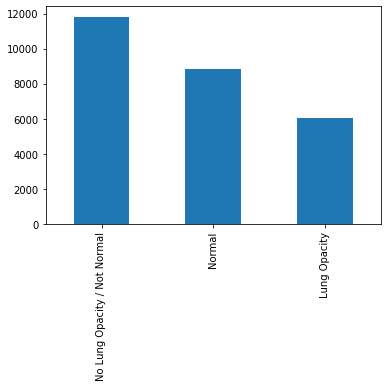

In [76]:
uniqueDF['class'].value_counts().plot.bar()

In [77]:
# Read the test label
stageLabelDF = pd.read_csv('./rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
stageLabelDF.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [78]:
stageLabelDF.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [79]:
stageLabelDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [80]:
print("unique count = {}".format(stageLabelDF.count()))

unique count = patientId    30227
x             9555
y             9555
width         9555
height        9555
Target       30227
dtype: int64


In [81]:
duplicateLabelRowsDF = stageLabelDF[stageLabelDF.duplicated()]
print("duplicate rows count {}".format(duplicateLabelRowsDF.count()))

duplicate rows count patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


In [82]:
# check distribution of data based on class
stageLabelDF['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

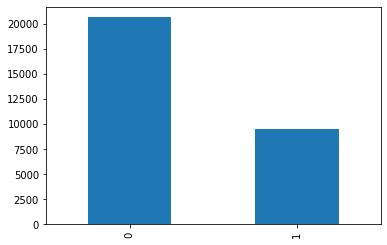

In [83]:
# check the distribution of data
stageLabelDF['Target'].value_counts().plot.bar()

In [84]:
# merge the dataset
mergedDF = uniqueDF.merge(stageLabelDF, on = 'patientId', how = 'left')
mergedDF.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
